In [1]:
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers
from pytorch_lightning import Trainer
import numpy as np
import pandas as pd

from net import SimpleNet
from net_lstm import SimpleLSTM
from net_transformer import SimpleTimeSeriesTransformer

from datamodule import Datamodule
from model import FlightModel

from file_parsing_utils import create_csv_dict
from coordinate_transform import CoordinateEnum, helper_get_coordinate_system_based_on_enum
from iterate_flights import itterate_flights, build_features, flight_tensor_chunk_itterator
from model import iterative_path_predict
from coordinate_transform import  haversine

from glob import glob 
import copy
from collections import defaultdict

from folium_utils import create_folium_map
import folium

from matplotlib import pyplot as plt

In [2]:
def dummy_net(dummy_arg):
    return 0.01 * torch.ones((32, 2, 1))


def dummy_net2(dummy_arg):
    # Create a tensor with the desired values for timesteps
    timestep_values = torch.tensor([0.01, 0.02, 0.03])
    
    # Repeat the tensor for each batch and channel
    dummy_tensor = timestep_values.repeat(32, 2, 1)
    
    return dummy_tensor

In [3]:
# '/Users/aleksandranikevich/Desktop/AircraftTrajectory/flight_pattern_of_life-main/models/test51/models/epoch=0-step=40000.ckpt'
import re
from glob import glob

def get_model_paths(experiment_name, models_dir=None):
    if models_dir is None:
        models_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/flight_pattern_of_life-main/models/'

    experiment_dir = models_dir + experiment_name + "/"
    models_dir = experiment_dir + "models/"
    paths = glob(models_dir + "*.ckpt")

    def extract_step_number(path):
        match = re.search(r"step=(\d+)", path)
        return int(match.group(1)) if match else float('inf')  # Use 'inf' for 'last.ckpt' to sort it last

    sorted_paths = sorted(paths, key=extract_step_number)
    return sorted_paths

# Example usage
sorted_paths = get_model_paths("test60")
sorted_paths[-2]


# model_path = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/flight_pattern_of_life-main/models/test51/models/epoch=0-step=40000.ckpt'
# model = FlightModel.load_from_checkpoint(checkpoint_path=model_path, 
#                                          map_location='cpu', 
#                                          model=net, 
#                                          loss_fn=loss_fn, 
#                                          optimizer=optimizer, 
#                                          max_num_val_maps=max_num_val_maps, 
#                                          n_future_timesteps=10, 
#                                          mean=mean, 
#                                          std=std)

# # dummy tensor
# test_dataloader_iterator = test_dataloader.__iter__()
# tensors_dict = next(test_dataloader_iterator)
# dummy_input_tensor = tensors_dict["input_tensor"].to("cpu")


# model.eval()
# with torch.no_grad():
#     dummy_output = model(dummy_input_tensor)

'/Users/aleksandranikevich/Desktop/AircraftTrajectory/flight_pattern_of_life-main/models/test60/models/epoch=0-step=120000.ckpt'

In [4]:
coordinate_system_enum = CoordinateEnum.LatLongCoordinates
coordinate_system = helper_get_coordinate_system_based_on_enum(coordinate_enum=coordinate_system_enum)

auxiliary_input_channels = [
                            "diff_time", 
                            "flight_course_corrected", 
                            "flight_course_unknown", 
                            ]

auxiliary_output_channels = []


len_coordinate_system  = len(coordinate_system)
desired_input_features = coordinate_system  + auxiliary_input_channels
desired_output_features = coordinate_system  + auxiliary_output_channels
desired_features_input_and_output = coordinate_system  + auxiliary_input_channels + auxiliary_output_channels

num_input_features = len(desired_input_features)
num_output_features = len(desired_output_features)


num_res_blocks = 4
intermediate_channels = 64
in_channels = len(coordinate_system) + len(auxiliary_input_channels)
out_channels = len(coordinate_system)


num_output_rows = 1
num_res_blocks = 4
intermediate_channels = 64
in_channels = len(coordinate_system) + len(auxiliary_input_channels)
out_channels = len(coordinate_system)

dilation = [1 if i % 2 == 0 else 2 for i in range(num_res_blocks + 2)]
net = SimpleNet(in_channels=in_channels, 
                out_channels=out_channels, 
                intermediate_channels=intermediate_channels, 
                num_res_blocks=num_res_blocks, 
                num_output_rows=num_output_rows, 
                dilation = dilation, 
                kernel_size = 27, 
                use_bn_norm=False, #True, 
                stride=1, 
                bias=True)

debug use batch norm:  False
debug use batch norm:  False
debug use batch norm:  False
debug use batch norm:  False
debug use batch norm:  False
debug use batch norm:  False
debug use batch norm:  False
debug use batch norm:  False
debug use batch norm:  False
debug use batch norm:  False


In [5]:
max_num_val_maps = 8
loss_fn = torch.nn.functional.mse_loss
optimizer = None #                               TODO 
mean = None
std = None

# model = FlightModel.load_from_checkpoint(checkpoint_path=sorted_paths[-2], 
#                                         map_location='cpu', 
#                                         model=net, 
#                                         loss_fn=loss_fn, 
#                                         optimizer=optimizer, 
#                                         max_num_val_maps=max_num_val_maps, 
#                                         n_future_timesteps=10, 
#                                         mean=mean, 
#                                         std=std)

model_simple_cnn = FlightModel.load_from_checkpoint(checkpoint_path=sorted_paths[-2], 
                    map_location='cpu', 
                    model=net, 
                    coordinate_system_enum=coordinate_system_enum, 
                    loss_fn=loss_fn, 
                    optimizer=optimizer, 
                    max_num_val_maps = max_num_val_maps, 
                    n_future_timesteps = 10, 
                    mean=mean, 
                    std=std)

Using Default model weights initialization


In [6]:
num_lstm_layers = 12
hidden_size = 64
#net = SimpleLSTM(in_channels, num_lstm_layers, out_channels)
net_simple_lstm = SimpleLSTM(in_channels, num_lstm_layers, out_channels, hidden_size=hidden_size, out_timesteps=num_output_rows) 


num_transformer_blocks_stacked = 4
hidden_dim = 64
nhead = 8
num_input_rows_total = 100
net_simple_trasformer = SimpleTimeSeriesTransformer(in_channels, num_input_rows_total, num_transformer_blocks_stacked, out_channels, num_output_rows, hidden_dim, nhead)


model_path_lstm = get_model_paths("test62")[-2]
model_path_transformer = get_model_paths("test63")[-2]



model_simple_lstm = FlightModel.load_from_checkpoint(checkpoint_path=model_path_lstm, 
                    map_location='cpu', 
                    model=net_simple_lstm, 
                    coordinate_system_enum=coordinate_system_enum, 
                    loss_fn=loss_fn, 
                    optimizer=optimizer, 
                    max_num_val_maps = max_num_val_maps, 
                    n_future_timesteps = 10, 
                    mean=mean, 
                    std=std)


model_simple_trasformer = FlightModel.load_from_checkpoint(checkpoint_path=model_path_transformer, 
                    map_location='cpu', 
                    model=net_simple_trasformer, 
                    coordinate_system_enum=coordinate_system_enum, 
                    loss_fn=loss_fn, 
                    optimizer=optimizer, 
                    max_num_val_maps = max_num_val_maps, 
                    n_future_timesteps = 10, 
                    mean=mean, 
                    std=std)

Using Default model weights initialization
Using Default model weights initialization


/opt/anaconda3/envs/trajectory/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
num_workers = 1

num_input_rows_total = 100
min_rows_input = 100
num_output_rows = 1


individual_flights_dir = "/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/"
flight_dfs = create_csv_dict(individual_flights_dir)

datamodule = Datamodule(all_flight_dataframes_dict = flight_dfs, 
                        num_input_rows_total = num_input_rows_total, 
                        min_rows_input = min_rows_input, 
                        num_output_rows = 1, 
                        coordinate_system_enum = coordinate_system_enum,
                        auxiliary_input_channels = auxiliary_input_channels,
                        auxiliary_output_channels = auxiliary_output_channels,
                        train_prop = 0.8, 
                        batch_size = 32, 
                        num_workers = num_workers, 
                        pin_memory = True,)

train_dataloader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()

# dummy tensor
test_dataloader_iterator = test_dataloader.__iter__()
tensors_dict = next(test_dataloader_iterator)

In [8]:
flight_dfs.keys()

dict_keys(['150171', '164344', '123483', '90107', '134434', '146014', '180338', '68524', '89816', '211338', '149860', '86062', '122551', '165296', '116764', '130094', '177753', '59263', '75895', '128857', '143566', '208215', '113216', '199215', '71409', '62822', '83510', '127023', '161636', '155403', '184798', '105373', '129985', '53759', '74947', '131146', '175004', '222328', '141231', '111541', '125774', '81247', '168589', '80395', '163161', '200078', '157354', '191078', '79664', '133611', '97322', '216921', '166413', '48123', '201996', '136363', '190996', '92650', '47957', '60749', '102156', '145691', '144743', '103084', '46885', '93782', '170576', '191844', '120206', '84735', '114033', '190398', '78584', '111773', '169669', '47359', '81075', '162281', '125546', '175236', '139119', '141003', '107616', '120808', '65009', '158912', '97110', '133423', '124494', '163353', '157166', '79456', '98964', '73950', '92462', '136151', '156888', '102364', '81849', '139925', '194738', '166621', '

In [9]:
flight_dfs['150171']

{'LTA941': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/150171/LTA941/150171_LTA941.csv',
 'SKW5664': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/150171/SKW5664/150171_SKW5664.csv',
 'N9803H': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/150171/N9803H/150171_N9803H.csv'}

In [10]:
flight_dfs['150171']

{'LTA941': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/150171/LTA941/150171_LTA941.csv',
 'SKW5664': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/150171/SKW5664/150171_SKW5664.csv',
 'N9803H': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/150171/N9803H/150171_N9803H.csv'}

In [9]:
desired_keys = ['150171', '164344', '123483', '90107', '134434', '146014', '180338', '68524', '89816']
eval_flights_dfs = {key: flight_dfs[key] for key in desired_keys if key in flight_dfs}

In [11]:
# eval_flights_iter = itterate_flights(eval_flights_dfs, flight_dictionary_pre_loaded = False, shuffle = False)
# next(eval_flights_iter)

def flightpath_iterator(flights_dict, 
                        flight_dictionary_pre_loaded, 
                        desired_input_features, 
                        desired_output_features, 
                        min_rows_input, 
                        num_input_rows_total, 
                        num_output_rows, 
                        len_coordinate_system, 
                        shuffle_flights, 
                        shuffle_chunks,
                        bool_yield_meta_flightpath = True, 
                        force_new_flightpath_every_val_step = False
                        ):
    
    iter_flights = itterate_flights(flights_dict, flight_dictionary_pre_loaded = flight_dictionary_pre_loaded, shuffle = shuffle_flights)
    for flightseries in iter_flights:
        if flightseries is None:
            break

        (msn, flight_id), flight_df = flightseries 
        flight_df_input_features, flight_df_output_features= build_features(flight_df, desired_input_features, desired_output_features)

        full_input_tensor = torch.as_tensor(flight_df_input_features.to_numpy(), dtype=torch.float32)
        full_output_tensor = torch.as_tensor(flight_df_output_features.to_numpy(), dtype=torch.float32)

        # now create iterator to get individual "chunks" of this timeseries data
        iter_tensor_chunks = flight_tensor_chunk_itterator( input_features_tensor_full = full_input_tensor, 
                                                            output_features_tensor_full = full_output_tensor, 
                                                            min_rows_input = min_rows_input, 
                                                            num_input_rows_total = num_input_rows_total, 
                                                            num_output_rows = num_output_rows, 
                                                            register_buffer_input = None, 
                                                            register_buffer_output = None,
                                                            shuffle_chunks=shuffle_chunks)

        for input_output_tensors_dict in iter_tensor_chunks:
            if input_output_tensors_dict is None:
                break


            # # Get last coordinate (coordinate at last timestep) | Normalization
            last_coor = input_output_tensors_dict["input_tensor"][-1, :len_coordinate_system].clone()
            input_output_tensors_dict["normalization_tensor"] = torch.unsqueeze(last_coor, dim=0)  # torch.unsqueeze(t, dim=0)


            # re-arrange tensor to be Batch x Channels x Timesteps (pytorch lightning will take care of stacking the batch dim)
            excempt_from_permute_keys = set(["zero_pad_rows", "chunk_index"])
            #keys_permute = set(input_output_tensors_dict.keys()) - excempt_from_permute_keys
            input_output_tensors_dict_dims_rearranged = {key: (input_output_tensors_dict[key].permute(1, 0) if key not in excempt_from_permute_keys else input_output_tensors_dict[key]) for key in input_output_tensors_dict.keys()}


            # Add meta information
            if bool_yield_meta_flightpath:
                input_output_tensors_dict_dims_rearranged["meta_flightpath"] = flights_dict[msn][flight_id]
                if not flight_dictionary_pre_loaded:
                    input_output_tensors_dict_dims_rearranged["meta_flightpath"] = pd.read_csv(flights_dict[msn][flight_id])
            input_output_tensors_dict_dims_rearranged["meta_msn"] = msn
            input_output_tensors_dict_dims_rearranged["meta_flight_id"] = flight_id

            
            yield input_output_tensors_dict_dims_rearranged

            # If Validation dataloader, get new flight every val step
            if force_new_flightpath_every_val_step:
                break

    yield None


In [12]:
desired_keys = ['150171', '164344', '123483', '90107', '134434', '146014', '180338', '68524', '89816']
eval_flights_dfs = {key: flight_dfs[key] for key in desired_keys if key in flight_dfs}

flight_dictionary_pre_loaded = False

num_predict_steps = 10
flightpath_iter = flightpath_iterator(flights_dict=eval_flights_dfs, 
                        flight_dictionary_pre_loaded=flight_dictionary_pre_loaded, 
                        desired_input_features=desired_input_features, 
                        desired_output_features=desired_output_features, 
                        min_rows_input=min_rows_input, 
                        num_input_rows_total=num_input_rows_total, 
                        num_output_rows=num_predict_steps, 
                        len_coordinate_system=len_coordinate_system, 
                        shuffle_flights = False, 
                        shuffle_chunks = False, 
                        bool_yield_meta_flightpath = True, 
                        force_new_flightpath_every_val_step = False
                        )

In [14]:
d = next(flightpath_iter)

In [15]:
d["input_tensor"]

tensor([[ 4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
          4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
          4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
          4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
          4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
          4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1973e+01,  4.1973e+01,
          4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
          4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
          4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
          4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
          4.1973e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,
          4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,
          4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,
          4.1971e+01,  4.1971e+01,  4.

In [16]:
d["output_tensor"]

tensor([[ 41.9704,  41.9704,  41.9704,  41.9703,  41.9704,  41.9704,  41.9704,
          41.9705,  41.9704,  41.9704],
        [-87.9027, -87.9027, -87.9026, -87.9027, -87.9025, -87.9024, -87.9024,
         -87.9024, -87.9024, -87.9023]])

In [13]:
# iterative_path_predict(batch_dict, model, coordinate_system_enum, num_predict_steps, bool_normalize_center = False)

model1 = model_simple_cnn
model2 = model_simple_lstm
model3 = model_simple_trasformer

# d = next(flightpath_iter)
# msn = d["meta_msn"]
# flight_id = d["meta_flight_id"]

results_dict = defaultdict(lambda: defaultdict(list))
###flightpaths = {(msn, flight_id): copy.deepcopy(d["meta_flightpath"])}
flightpaths = {}

for idx_iter, d in enumerate(flightpath_iter):
    if d is None:
        break

    # if msn != d["meta_msn"] and flight_id != d["meta_flight_id"]:
    #     msn = d["meta_msn"]
    #     flight_id = d["meta_flight_id"]
    #     flightpaths[(msn, flight_id)] = copy.deepcopy(d["meta_flightpath"])

    msn = d['meta_msn']
    flight_id = d['meta_flight_id']
    if (msn, flight_id) not in flightpaths:
        flightpaths[(msn, flight_id)] = copy.deepcopy(d['meta_flightpath'])


    # dict_keys(['input_tensor', 'output_tensor', 'zero_pad_rows', 'chunk_index', 'normalization_tensor', 'meta_flightpath', 'meta_msn', 'meta_flight_id'])
    input_tensor = d["input_tensor"]
    output_tensor = d["output_tensor"]



    input_tensor = torch.unsqueeze(input_tensor, dim=0)
    d["input_tensor"] = input_tensor



    pass_in_dict = {"input_tensor": d["input_tensor"].clone(), "normalization_tensor": d["normalization_tensor"].clone()}


    # Predictions from our CNN, LSTM, Transformer models
    iterative_predictions_tensor_np1 = iterative_path_predict(batch_dict=pass_in_dict, 
                                                             model=model1, 
                                                             coordinate_system_enum=coordinate_system_enum, 
                                                             num_predict_steps=num_predict_steps, 
                                                             bool_normalize_center = True, 
                                                             bool_with_eval_model = True
                                                             )
    
    pass_in_dict = {"input_tensor": d["input_tensor"].clone(), "normalization_tensor": d["normalization_tensor"].clone()}
    iterative_predictions_tensor_np2 = iterative_path_predict(batch_dict=pass_in_dict, 
                                                             model=model2, 
                                                             coordinate_system_enum=coordinate_system_enum, 
                                                             num_predict_steps=num_predict_steps, 
                                                             bool_normalize_center = True, 
                                                             bool_with_eval_model = True
                                                             )
    
    pass_in_dict = {"input_tensor": d["input_tensor"].clone(), "normalization_tensor": d["normalization_tensor"].clone()}
    iterative_predictions_tensor_np3 = iterative_path_predict(batch_dict=pass_in_dict, 
                                                             model=model3, 
                                                             coordinate_system_enum=coordinate_system_enum, 
                                                             num_predict_steps=num_predict_steps, 
                                                             bool_normalize_center = True, 
                                                             bool_with_eval_model = True)
    

    results_dict[(msn, flight_id)]["prediction_cnn"].append(iterative_predictions_tensor_np1)
    results_dict[(msn, flight_id)]["prediction_lstm"].append(iterative_predictions_tensor_np2)
    results_dict[(msn, flight_id)]["prediction_trasformer"].append(iterative_predictions_tensor_np3)
    results_dict[(msn, flight_id)]['chunk_index'].append(d['chunk_index'])
    results_dict[(msn, flight_id)]['ground_truth'].append(output_tensor.detach().cpu().numpy())
    
    
    if idx_iter > 2000:
        break


In [14]:
tuple_key = list(results_dict.keys())[0]
print("results_dict prd list:", len(results_dict[tuple_key]['prediction_cnn']))
print("flight df shape: ", flightpaths[tuple_key].shape)

results_dict prd list: 1768
flight df shape:  (807, 13)


In [27]:
for key, val in flightpaths.items():
    print(key, val.shape)

('150171', 'SKW5664') (807, 13)
('164344', 'EJA151') (945, 13)


In [16]:
list(results_dict.keys())

[('150171', 'SKW5664'), ('164344', 'EJA151')]

In [17]:
flightpaths.keys()

dict_keys([('150171', 'SKW5664'), ('164344', 'EJA151')])

In [18]:
tuple_key = list(results_dict.keys())[0]

color_cnn = "green"
color_lstm = "blue"
color_transformer = 'orange'


flightpath_compleate = flightpaths[tuple_key][["Latitude", "Longitude"]].to_numpy()
min_lat, max_lat = np.min(flightpath_compleate[:, 0]), np.max(flightpath_compleate[:, 0])
min_long, max_long = np.min(flightpath_compleate[:, 1]), np.max(flightpath_compleate[:, 1])

m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.15, border_long_prop=0.15, tiles=None) #"Cartodb dark_matter")
folium.PolyLine(locations=flightpath_compleate, color='black', weight=2.5, opacity=1).add_to(m)


num_predictions = len(results_dict[tuple_key]["prediction_cnn"])
for idx_pred in range(30, num_predictions, 10):
    cnn_prediction = results_dict[tuple_key]["prediction_cnn"][idx_pred][0]
    lstm_prediction = results_dict[tuple_key]["prediction_lstm"][idx_pred][0]
    transformer_prediction = results_dict[tuple_key]["prediction_trasformer"][idx_pred][0]

    folium.PolyLine(locations=cnn_prediction.T, color=color_cnn, weight=2.5, opacity=1).add_to(m)
    folium.PolyLine(locations=lstm_prediction.T, color=color_lstm, weight=2.5, opacity=1).add_to(m)
    folium.PolyLine(locations=transformer_prediction.T, color=color_transformer, weight=2.5, opacity=1).add_to(m)


m


In [23]:
dist_errors_cnn_list_of_lists = []
dist_errors_lstm_list_of_lists = []
dist_errors_transformer_list_of_lists = []
ground_truth_distance_list_of_lists = []

# plots of error
num_predictions = len(results_dict[tuple_key]["prediction_cnn"])
flightpath_compleate = flightpaths[tuple_key][["Latitude", "Longitude"]].to_numpy()
for idx_pred in range(30, num_predictions-11, 10):
    cnn_prediction = results_dict[tuple_key]["prediction_cnn"][idx_pred][0]
    lstm_prediction = results_dict[tuple_key]["prediction_lstm"][idx_pred][0]
    transformer_prediction = results_dict[tuple_key]["prediction_trasformer"][idx_pred][0]

    ground_truth = results_dict[tuple_key]["ground_truth"][idx_pred]
    idx_current_position = results_dict[tuple_key]['chunk_index'][idx_pred]
    current_position = flightpath_compleate[idx_current_position]
    current_lat = current_position[0]
    current_long = current_position[1]

    # haversine(lat1, lon1, lat2, lon2)
    
    num_pred = cnn_prediction.shape[1]
    dist_errors_cnn_list = []
    dist_errors_lstm_list = []
    dist_errors_transformer_list = []
    ground_truth_distance_list = []
    for i in range(num_pred):

        next_ground_truth_coor = flightpath_compleate[idx_current_position + i+1] # + 1 because i starts with zero 
        next_ground_truth_coor_lat = next_ground_truth_coor[0]
        next_ground_truth_coor_long = next_ground_truth_coor[1]

        pred_lat_cnn = cnn_prediction[0][i]
        pred_long_cnn = cnn_prediction[1][i]

        pred_lat_lstm = lstm_prediction[0][i]
        pred_long_lstm = lstm_prediction[1][i]

        pred_lat_transformer = transformer_prediction[0][i]
        pred_long_transformer = transformer_prediction[1][i]

        dist_error_cnn = haversine(current_lat, current_long, pred_lat_cnn, pred_long_cnn)
        dist_error_lstm = haversine(current_lat, current_long, pred_lat_lstm, pred_long_lstm)
        dist_error_trasformer = haversine(current_lat, current_long, pred_lat_transformer, pred_long_transformer)
        dist_ground_truth = haversine(current_lat, current_long, next_ground_truth_coor_lat, next_ground_truth_coor_long)

        dist_errors_cnn_list.append(dist_error_cnn)
        dist_errors_lstm_list.append(dist_error_lstm)
        dist_errors_transformer_list.append(dist_error_trasformer)
        ground_truth_distance_list.append(dist_ground_truth)

    
    dist_errors_cnn_list_of_lists.append(dist_errors_cnn_list)
    dist_errors_lstm_list_of_lists.append(dist_errors_lstm_list)
    dist_errors_transformer_list_of_lists.append(dist_errors_transformer_list)
    ground_truth_distance_list_of_lists.append(ground_truth_distance_list)


    

    
    



IndexError: index 807 is out of bounds for axis 0 with size 807

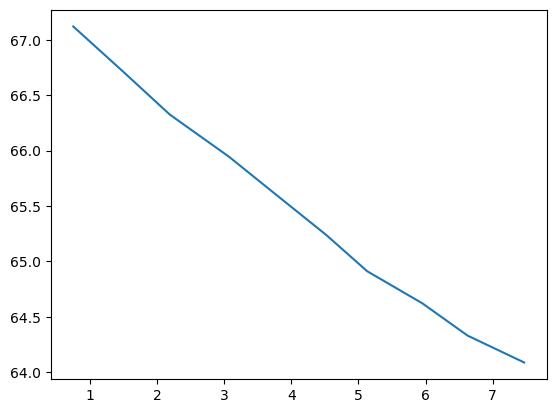

In [20]:
cnn_error_arr = np.array(dist_errors_cnn_list_of_lists)
gt_distance = np.array(ground_truth_distance_list_of_lists)

erro_dist_average = np.mean(cnn_error_arr, axis=0)
gt_disance_avg = np.median(gt_distance, axis=0)
plt.figure()
#plt.plot(erro_dist_average)
plt.plot(gt_disance_avg, erro_dist_average)
# for idx in range(cnn_error_arr.shape[0]):
#     plt.plot(cnn_error_arr[idx])
# for idx in range(cnn_error_arr.shape[0]):
#     plt.plot(gt_distance[idx], cnn_error_arr[idx])

In [ ]:
cnn_error_arr = np.array(dist_errors_cnn_list_of_lists)
gt_distance = np.array(ground_truth_distance_list_of_lists)

In [26]:
len(results_dict[tuple_key]["prediction_cnn"]), flightpath_compleate.shape

(1768, (807, 2))

In [126]:
gt_disance_avg

array([0.07377044, 0.14530945, 0.2145117 , 0.28313322, 0.35029518,
       0.42040518, 0.48624092, 0.55574934, 0.62653218, 0.70039544])

In [113]:
np.array(dist_errors_cnn_list_of_lists).shape, np.array(ground_truth_distance_list_of_lists).shape

((145, 10), (145, 10))

In [111]:
dist_errors_cnn_list_of_lists, len(dist_errors_cnn_list_of_lists)

([[0.4219937812308364,
   0.4291874419496725,
   0.4366921787409301,
   0.4427698561767877,
   0.44885566558015555,
   0.45575986830142223,
   0.46186038268599794,
   0.46796810264292943,
   0.4747464597733386,
   0.48101233301762775],
  [0.5106247172646851,
   0.5185748652215703,
   0.5259688361599318,
   0.5337376609799991,
   0.5406419067563051,
   0.5475811606848338,
   0.5539822358236882,
   0.5603748411685321,
   0.5656641123799773,
   0.5710301500433875],
  [0.5943811711972613,
   0.6022889667036395,
   0.6099478134124097,
   0.6168306982958869,
   0.6236571129932948,
   0.6291059235039727,
   0.6334335962105139,
   0.6382272924555406,
   0.6410065764984058,
   0.6421886442300065],
  [0.7064676120870106,
   0.7191950993436383,
   0.7325299415318893,
   0.7451657643651662,
   0.7591631459001624,
   0.772462997602051,
   0.7870862878785304,
   0.8010163394449729,
   0.8148754880884901,
   0.8280835763805964],
  [0.8172532655944391,
   0.8291785502550215,
   0.8403407586261006,
   

In [87]:
next_ground_truth_coor.shape

(1, 2)

In [99]:
num_predictions, flightpath_compleate.shape

(1278, (945, 2))

In [96]:
flightpaths[tuple_key]

,Unnamed: 0,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
0,103655297,164344,36T,EJA151,1715982115,36.08150,-115.16966,21.5,0xE02,1,2,5,70
1,103655298,164344,36T,EJA151,1715982119,36.08153,-115.16956,21.5,0xE02,1,2,5,70
2,103655299,164344,36T,EJA151,1715982120,36.08152,-115.16950,21.5,0xE02,1,2,11,102
3,103655300,164344,36T,EJA151,1715982121,36.08153,-115.16942,21.5,0xE02,1,10,14,81
4,103655301,164344,36T,EJA151,1715982122,36.08154,-115.16935,21.5,0xE02,1,8,12,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,103656237,164344,36T,EJA151,1715985741,33.63794,-111.89314,18.0,AIG200,1,10,117,225
941,103656238,164344,36T,EJA151,1715985746,33.63619,-111.89519,18.0,AIG200,1,5,115,224
942,103656239,164344,36T,EJA151,1715985750,33.63436,-111.89728,17.0,AIG200,1,10,115,224
943,103656240,164344,36T,EJA151,1715985752,33.63358,-111.89814,16.0,AIG200,1,1,117,223


In [82]:
current_position

array([  36.08352, -115.16811])

In [84]:
cnn_prediction.shape

(2, 10)

In [76]:
cnn_prediction.shape, ground_truth.shape

((2, 10), (2, 10))

In [79]:
flightpath_compleate.shape

(945, 2)

In [78]:
cnn_prediction

array([[  36.061577,   36.060543,   36.0595  ,   36.058437,   36.057404,
          36.05637 ,   36.055363,   36.054386,   36.05342 ,   36.052498],
       [-115.175224, -115.17569 , -115.1762  , -115.17672 , -115.17721 ,
        -115.17766 , -115.178055, -115.17843 , -115.17883 , -115.179245]],
      dtype=float32)

In [56]:
tuple_key = ('150171', 'SKW5664')

color_cnn = "green"
color_lstm = "blue"
color_transformer = 'orange'


flightpath_compleate = flightpaths[tuple_key][["Latitude", "Longitude"]].to_numpy()
min_lat, max_lat = np.min(flightpath_compleate[:, 0]), np.max(flightpath_compleate[:, 0])
min_long, max_long = np.min(flightpath_compleate[:, 1]), np.max(flightpath_compleate[:, 1])

m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.15, border_long_prop=0.15, tiles=None) #"Cartodb dark_matter")
folium.PolyLine(locations=flightpath_compleate, color='black', weight=2.5, opacity=1).add_to(m)


num_predictions = len(results_dict[tuple_key]["prediction_cnn"])
for idx_pred in range(91, num_predictions, 10):
    cnn_prediction = results_dict[tuple_key]["prediction_cnn"][idx_pred][0]
    lstm_prediction = results_dict[tuple_key]["prediction_lstm"][idx_pred][0]
    transformer_prediction = results_dict[tuple_key]["prediction_trasformer"][idx_pred][0]

    folium.PolyLine(locations=cnn_prediction.T, color=color_cnn, weight=2.5, opacity=1).add_to(m)
    folium.PolyLine(locations=lstm_prediction.T, color=color_lstm, weight=2.5, opacity=1).add_to(m)
    folium.PolyLine(locations=transformer_prediction.T, color=color_transformer, weight=2.5, opacity=1).add_to(m)


m


In [52]:
flightpath_compleate.shape

(807, 2)

In [ ]:
flightpath_compleate = flightpath_compleate_pd[["Latitude", "Longitude"]].to_numpy()

timesteps = flightpath_compleate.shape[0]
flightpath_chunk = flightpath_compleate[int(0.5*timesteps): int(0.7*timesteps), :]


min_lat, max_lat = np.min(flightpath_chunk[:, 0]), np.max(flightpath_chunk[:, 0])
min_long, max_long = np.min(flightpath_chunk[:, 1]), np.max(flightpath_chunk[:, 1])

m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.15, border_long_prop=0.15, tiles=None) #"Cartodb dark_matter")
folium.PolyLine(locations=flightpath_compleate, color='black', weight=2.5, opacity=1).add_to(m)
m

In [58]:
m2 = copy.deepcopy(m)

TypeError: Template.__new__() missing 1 required positional argument: 'source'

In [41]:
# dict_keys(['prediction_cnn', 'prediction_lstm', 'prediction_trasformer', 'chunk_index'])
results_dict[('150171', 'SKW5664')]['chunk_index']

[9, 10, 11, 12, 13, 14, 15]

In [ ]:
# # min_lat, max_lat = np.min(flightpath_chunk[:, 0]), np.max(flightpath_chunk[:, 0])
# # min_long, max_long = np.min(flightpath_chunk[:, 1]), np.max(flightpath_chunk[:, 1])

# m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.2, border_long_prop=0.15, tiles=None) #"Cartodb dark_matter")
# folium.PolyLine(locations=flightpath_compleate, color='black', weight=2.5, opacity=1).add_to(m)

# for predicted_flightpath in predicted_paths_list:
#     folium.PolyLine(locations=predicted_flightpath, color='blue', weight=2.5, opacity=1).add_to(m)



# m

In [59]:
output_tensor

tensor([[ 28.0092,  28.0071,  28.0051,  28.0030,  28.0009,  27.9988,  27.9968,
          27.9948,  27.9926,  27.9904],
        [-80.7253, -80.7252, -80.7253, -80.7252, -80.7250, -80.7250, -80.7248,
         -80.7250, -80.7250, -80.7248]])

In [ ]:
from collections import defaultdict

# Create a nested defaultdict
nested_dict = defaultdict(lambda: defaultdict(list))

# Dummy tuples
tuples = [
    ('a', 'b'),
    ('a', 'c'),
    ('b', 'c'),
    ('a', 'b'),
    ('b', 'c')
]

# Iterate over the tuples and append values to the nested defaultdict
for t in tuples:
    nested_dict[t]['key1'].append('value1')
    nested_dict[t]['key2'].append('value2')
    nested_dict[t]['key3'].append('value3')

# Print the nested defaultdict to see the result
for key, value in nested_dict.items():
    print(f"{key}: {dict(value)}")


In [30]:
iterative_predictions_tensor_np1

array([[[ 41.97033 ,  41.970306,  41.970276,  41.970253,  41.970222,
          41.9702  ,  41.970173,  41.970142,  41.970116,  41.97009 ],
        [-87.90243 , -87.90237 , -87.902306, -87.902245, -87.90218 ,
         -87.90212 , -87.902054, -87.901985, -87.901924, -87.901855]]],
      dtype=float32)

In [31]:
iterative_predictions_tensor_np2

array([[[ 41.970303,  41.97027 ,  41.97023 ,  41.970192,  41.970154,
          41.970116,  41.970078,  41.97004 ,  41.97    ,  41.969963],
        [-87.902466, -87.90244 , -87.90242 , -87.9024  , -87.902374,
         -87.90235 , -87.90233 , -87.902306, -87.902275, -87.90225 ]]],
      dtype=float32)

In [32]:
d["output_tensor"]

tensor([[ 41.9704,  41.9704,  41.9705,  41.9704,  41.9704,  41.9704,  41.9704,
          41.9704,  41.9704,  41.9704],
        [-87.9024, -87.9024, -87.9024, -87.9024, -87.9023, -87.9023, -87.9022,
         -87.9021, -87.9021, -87.9020]])

In [33]:
41.9704*2, -87.9021*2

(83.9408, -175.8042)

In [22]:
d["input_tensor"]

tensor([[[ 4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
           4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
           4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
           4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
           4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
           4.1974e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
           4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
           4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
           4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
           4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1972e+01,
           4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,
           4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,
           4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1971e+01,  4.1971e+01,
           4.1971e+01,  4

In [23]:
d.keys()

dict_keys(['input_tensor', 'output_tensor', 'zero_pad_rows', 'chunk_index', 'normalization_tensor', 'meta_flightpath', 'meta_msn', 'meta_flight_id'])

In [24]:

# predicted_paths_list = []
# ground_truth_paths_list = []



# # update the num_rows variable based on the zero-padded tensor
# num_rows, _ = inpput_tensor_zero_padded.shape

# num_tensor_chunks = num_rows - num_input_rows_total - num_output_rows
# indecies_tensor_chunks_shuffled = np.arange(num_tensor_chunks)
# ###np.random.shuffle(indecies_tensor_chunks_shuffled)
# for i in indecies_tensor_chunks_shuffled[100::2][:20]: #range(num_tensor_chunks):
#     input_tensor_chunk = inpput_tensor_zero_padded[i: i + num_input_rows_total].T
#     output_tensor_chunk = output_tensor_zero_padded[i + num_input_rows_total: i + num_input_rows_total + num_output_rows].T
#     ground_truth_chunk = output_tensor_zero_padded[i + num_input_rows_total: i + num_input_rows_total + N_prediction_steps].T
#     ground_truth_chunk_lat_long = predicted_path_complex_to_lat_long_stacked(ground_truth_chunk)

#     current_position_to_next_step_debug = output_tensor_zero_padded[i + num_input_rows_total -1: i + num_input_rows_total + 2].T
#     current_position_to_next_step_debug_lat_long = predicted_path_complex_to_lat_long_stacked(current_position_to_next_step_debug)[0].T # without if check like the other tensors

#     predicted_flightpath_lat_long = input_tensor_chunk_to_predicted_lat_long_path(model, input_tensor_chunk, N_prediction_steps=N_prediction_steps)
#     if len(predicted_flightpath_lat_long.shape) == 3:
#         predicted_flightpath_lat_long = predicted_flightpath_lat_long[0]
#     predicted_flightpath_lat_long = predicted_flightpath_lat_long.T

#     if len(ground_truth_chunk_lat_long.shape) == 3:
#         ground_truth_chunk_lat_long = ground_truth_chunk_lat_long[0]
#     ground_truth_chunk_lat_long = ground_truth_chunk_lat_long.T

#     ###folium.PolyLine(locations=predicted_flightpath_lat_long, color='red', weight=2.5, opacity=1).add_to(m)
#     #folium.PolyLine(locations=ground_truth_chunk_lat_long, color='green', weight=2.5, opacity=1).add_to(m)

#     #folium.PolyLine(locations=current_position_to_next_step_debug_lat_long, color='blue', weight=4.5, opacity=1).add_to(m)

#     predicted_paths_list.append(predicted_flightpath_lat_long)
#     ground_truth_paths_list.append(ground_truth_chunk_lat_long)
    

#     #break

# # Lat bounds on map 
# min_lat_predicted = np.min([np.min(some_flightpath[:, 0]) for some_flightpath in predicted_paths_list])
# min_lat_ground_truth = np.min([np.min(some_flightpath[:, 0]) for some_flightpath in ground_truth_paths_list])
# min_lat = min(min_lat_predicted, min_lat_ground_truth)

# max_lat_predicted = np.amax([np.amax(some_flightpath[:, 0]) for some_flightpath in predicted_paths_list])
# max_lat_ground_truth = np.amax([np.amax(some_flightpath[:, 0]) for some_flightpath in ground_truth_paths_list])
# max_lat = max(max_lat_predicted, max_lat_ground_truth)

# # Long bounds on map 
# min_long_predicted = np.min([np.min(some_flightpath[:, 1]) for some_flightpath in predicted_paths_list])
# min_long_ground_truth = np.min([np.min(some_flightpath[:, 1]) for some_flightpath in ground_truth_paths_list])
# min_long = min(min_long_predicted, min_long_ground_truth)

# max_long_predicted = np.amax([np.amax(some_flightpath[:, 1]) for some_flightpath in predicted_paths_list])
# max_long_ground_truth = np.amax([np.amax(some_flightpath[:, 1]) for some_flightpath in ground_truth_paths_list])
# max_long = max(max_long_predicted, max_long_ground_truth)



# # min_lat, max_lat = np.min(flightpath_chunk[:, 0]), np.max(flightpath_chunk[:, 0])
# # min_long, max_long = np.min(flightpath_chunk[:, 1]), np.max(flightpath_chunk[:, 1])

# m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.2, border_long_prop=0.15, tiles=None) #"Cartodb dark_matter")
# folium.PolyLine(locations=flightpath_compleate, color='black', weight=2.5, opacity=1).add_to(m)

# for predicted_flightpath in predicted_paths_list:
#     folium.PolyLine(locations=predicted_flightpath, color='blue', weight=2.5, opacity=1).add_to(m)



# m

In [25]:
d = next(flightpath_iter)
d

{'input_tensor': tensor([[ 4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
           4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
           4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
           4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
           4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,  4.1974e+01,
           4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
           4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
           4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
           4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1973e+01,
           4.1973e+01,  4.1973e+01,  4.1973e+01,  4.1972e+01,  4.1972e+01,
           4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,
           4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,  4.1972e+01,
           4.1972e+01,  4.1972e+01,  4.1971e+01,  4.1971e+01,  4.1971e+01,
         

In [26]:
d.keys()

dict_keys(['input_tensor', 'output_tensor', 'zero_pad_rows', 'chunk_index', 'normalization_tensor', 'meta_flightpath', 'meta_msn', 'meta_flight_id'])

In [27]:
d['meta_flightpath']

,Unnamed: 0,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
0,164444875,150171,656,SKW5664,1716075887,41.97372,-87.90504,6.5,0xE02,1,1,5,37
1,164444876,150171,656,SKW5664,1716075888,41.97374,-87.90502,6.5,0xE02,1,1,5,37
2,164444877,150171,656,SKW5664,1716075890,41.97375,-87.90501,6.5,0xE02,1,1,1,37
3,164444878,150171,656,SKW5664,1716075891,41.97376,-87.90499,6.5,0xE02,1,1,4,56
4,164444879,150171,656,SKW5664,1716075892,41.97376,-87.90498,6.5,0xE02,1,1,2,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,164445677,150171,656,SKW5664,1716079237,43.54535,-84.06321,8.0,AIG200,1,10,143,226
803,164445678,150171,656,SKW5664,1716079241,43.54349,-84.06593,8.0,AIG200,1,7,139,227
804,164445679,150171,656,SKW5664,1716079245,43.54149,-84.06864,7.0,AIG200,1,10,141,224
805,164445680,150171,656,SKW5664,1716079250,43.53937,-84.07163,7.0,AIG200,1,1,132,226


In [28]:
msn_initial = 

SyntaxError: invalid syntax (2084470858.py, line 1)